  +-----------+  
  | __start__ |  
  +-----------+  
        *        
        *        
        *        
+--------------+ 
| orchestrator | 
+--------------+ 
        *        
        *        
        *        
  +---------+    
  | __end__ |    
  +---------+    


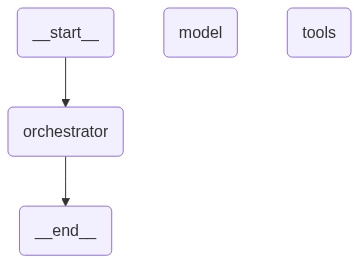

In [15]:
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_mistralai import ChatMistralAI
from langchain_tavily import TavilySearch
from pydantic import BaseModel
from langgraph.graph import StateGraph, START, END
from langgraph.graph import add_messages
from typing_extensions import TypedDict
from typing import Annotated
from dotenv import load_dotenv
load_dotenv()

llm = ChatMistralAI(
    model="mistral-medium-latest",
    temperature=0,
    max_retries=2,
)

tavily_search_tool = TavilySearch(
    max_results=5,
    topic="general",
    # include_answer=False,
    # include_raw_content=False,
    # include_images=False,
    # include_image_descriptions=False,
    # search_depth="basic",
    # time_range="day",
    # include_domains=None,
    # exclude_domains=None
)

def get_weather(city: str) -> str:  
    """Get weather for a given city."""
    return f"It's always sunny in {city}!"

tools = [get_weather, tavily_search_tool]
model =llm.bind_tools(tools)

class State(TypedDict):
    messages: Annotated[list, add_messages]

def custom_tools_condition(state):  
    # Check if there are tool calls using the same logic as tools_condition  
    if isinstance(state, list):  
        ai_message = state[-1]  
    elif isinstance(state, dict) and (messages := state.get("messages", [])):  
        ai_message = messages[-1]  
    else:  
        raise ValueError(f"No messages found in input state: {state}")  
      
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:  
        return "tools"  # Instead of "tools"  
    return "orchestrator"  # Instead of "__end__"

def model_node(state: State) -> State:
    res = model.invoke(state["messages"])
    return {"messages": res}

def orchestrator_node(state: State) -> State:
    return {"messages": state["messages"]}

def done_condition(state):
    if state["messages"][-1].content == "end":
        return "__end__"
    else:
        return "model"

builder = StateGraph(State)
builder.add_node("model", model_node)
builder.add_node("orchestrator", orchestrator_node)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "orchestrator")
builder.add_conditional_edges("orchestrator", done_condition)
builder.add_conditional_edges("model", custom_tools_condition)
builder.add_edge("tools", "model")
#builder.add_edge("orchestrator", END)

graph = builder.compile()
print(graph.get_graph().draw_ascii())
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [5]:
graph.invoke({"messages": [{"role": "user", "content": "provide the webpage of ksta."}]})

{'messages': [HumanMessage(content='provide the webpage of ksta.', additional_kwargs={}, response_metadata={}, id='3f854d48-715b-430a-866f-6f7770fe2763'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'bLD3I9qJ9', 'function': {'name': 'tavily_search', 'arguments': '{"query": "ksta webpage"}'}, 'index': 0}]}, response_metadata={'token_usage': {'prompt_tokens': 1148, 'total_tokens': 1163, 'completion_tokens': 15}, 'model_name': 'mistral-medium-latest', 'model': 'mistral-medium-latest', 'finish_reason': 'tool_calls'}, id='run-e7d9a4d9-0c80-4ab6-a64e-a5881075f254-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'ksta webpage'}, 'id': 'bLD3I9qJ9', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1148, 'output_tokens': 15, 'total_tokens': 1163}),
  ToolMessage(content='{"query": "ksta webpage", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Kentucky Science Teachers Association hosting annual conference Nov. 3-5", "url": 

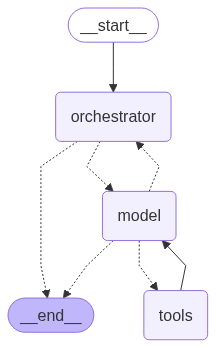

        +-----------+         
        | __start__ |         
        +-----------+         
              *               
              *               
              *               
      +--------------+        
      | orchestrator |        
      +--------------+        
         .         ..         
       ..            .        
      .               ..      
+-------+               .     
| model |.              .     
+-------+ ...           .     
    .        ...        .     
    .           ...     .     
    .              ..   .     
+-------+         +---------+ 
| tools |         | __end__ | 
+-------+         +---------+ 


In [ ]:
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_mistralai import ChatMistralAI
from langchain_tavily import TavilySearch
from pydantic import BaseModel
from langgraph.graph import StateGraph, START, END
from langgraph.graph import add_messages
from typing_extensions import TypedDict, Literal
from typing import Annotated
from dotenv import load_dotenv
load_dotenv()

llm = ChatMistralAI(
    model="mistral-medium-latest",
    temperature=0,
    max_retries=2,
)

tavily_search_tool = TavilySearch(
    max_results=5,
    topic="general",
)

def get_weather(city: str) -> str:  
    """Get weather for a given city."""
    return f"It's always sunny in {city}!"

tools = [get_weather, tavily_search_tool]
model =llm.bind_tools(tools)

class State(TypedDict):
    messages: Annotated[list, add_messages]

def custom_tools_condition(state: State) -> Literal["tools", "orchestrator"]:  
    # Get the last message from the state
    if isinstance(state, dict) and "messages" in state:
        messages = state["messages"]
        if messages and hasattr(messages[-1], "tool_calls"):
            return "tools"
    return "orchestrator"

def model_node(state: State) -> State:
    res = model.invoke(state["messages"])
    return {"messages": res}

def orchestrator_node(state: State) -> State:
    return {"messages": state["messages"]}

def done_condition(state):
    # Check if the last message indicates we're done
    if isinstance(state, dict) and "messages" in state:
        messages = state["messages"]
        if messages and messages[-1].content.strip().lower() == "end":
            return "__end__"
    return "model"

builder = StateGraph(State)
builder.add_node("model", model_node)
builder.add_node("orchestrator", orchestrator_node)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "orchestrator")
builder.add_conditional_edges("orchestrator", done_condition, path_map={"__end__": END, "model": "model"})
builder.add_conditional_edges("model", tools_condition, path_map={"tools": "tools", "__end__": "orchestrator"})
builder.add_edge("tools", "model")
builder.add_edge("orchestrator", END)

graph = builder.compile()
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))
print(graph.get_graph().draw_ascii())